In [80]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import Point
from sentence_transformers import SentenceTransformer, util
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss, accuracy_score, recall_score, f1_score, average_precision_score
from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import geometric_mean_score
from catboost import CatBoostClassifier

In [81]:
# merge the gentri label to the vectorization text
# use 'polygon' or 'wgs84_polygon', depend on what coordinate the label is
# load gentri label
lsoa_label = gpd.read_file("data/gentri_data/london_gentri_labeled.shp")
lsoa_label.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [82]:
stru_data = pd.read_csv("data/all_stru_data_added.csv")
print(lsoa_label.columns)
print(stru_data.columns)

Index(['LSOA code', 'LSOA11NM', '2019_final', 'Index of M', 'gentrified',
       'geometry'],
      dtype='object')
Index(['LSOA Code', 'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
       'all_dwelling', 'shared_per', 'converted_per', 'level_4_pop',
       'level_4_per', 'prof_occ_count', 'prof_occ_per', 'pro_sale_2019',
       'sale_avg', 'single_per', 'less_10km_per'],
      dtype='object')


In [83]:
stru_data = stru_data.rename(columns={'LSOA Code': 'LSOA code'})
lsoa_label = lsoa_label.merge(stru_data, on= "LSOA code", how="left")

In [84]:
# use the wgs84_polygon to join the label with text
# read the text
text = pd.read_parquet("sbert_encoded_data.parquet")
print(text.columns)

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_374', 'sbert_375', 'sbert_376', 'sbert_377', 'sbert_378',
       'sbert_379', 'sbert_380', 'sbert_381', 'sbert_382', 'sbert_383'],
      dtype='object', length=401)


In [85]:
# turn polygon coordinate into shapely 
# make sure to drop the null geodata
text_valid = text[text['wgs84_polygon.coordinates'].notnull()].copy()
text_valid["geometry"] = text_valid["wgs84_polygon.coordinates"].apply(lambda coords: Polygon(coords[0]))
# creat GeoDataFrame， set WGS84 coordinate
gdf_text = gpd.GeoDataFrame(text_valid, geometry="geometry", crs="EPSG:4326")

In [86]:
# set to 27700
gdf_27700 = gdf_text.to_crs("EPSG:27700")

In [87]:
joined = gpd.sjoin(gdf_27700, lsoa_label[["LSOA code", "geometry", "gentrified",
                                          'Index of M', '2019_final',
                                          "pop_growth_rate", "avg_den", "senior_per", "minority_per",
                                          'all_dwelling', 'shared_per', 'converted_per',
                                          'level_4_pop', 'level_4_per',
                                          'prof_occ_count', 'prof_occ_per',
                                          'sale_avg',
                                          'single_per',
                                          'less_10km_per']], 
                                          how="left", predicate="within")

In [88]:
# get the centroid of each polygon
gdf_27700["centroid"] = gdf_27700.geometry.centroid

In [89]:
# spatial join
joined_centroid = gpd.sjoin(gdf_27700.set_geometry("centroid"), lsoa_label[["LSOA code", "geometry", "gentrified", 
                                                                            'Index of M', '2019_final',
                                                                            "avg_den", "senior_per", "minority_per"]],
                                                                            how="left",predicate="within")

In [90]:
joined_cleaned = joined_centroid[joined_centroid["gentrified"].notna()].copy()
joined_cleaned.columns

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'geometry', 'centroid', 'index_right', 'LSOA code', 'gentrified',
       'Index of M', '2019_final', 'avg_den', 'senior_per', 'minority_per'],
      dtype='object', length=411)

In [91]:
lsoa_counts = joined_cleaned.groupby('LSOA code').size().reset_index(name='application_count')

<Axes: >

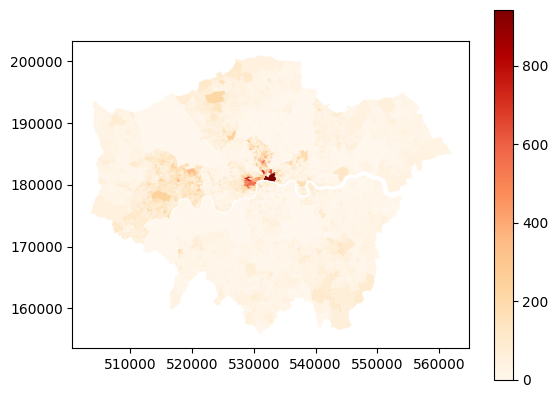

In [92]:
# gdf_lsoa: 是你读取的 LSOA 边界数据
lsoa_label = lsoa_label.merge(lsoa_counts, on='LSOA code', how='left')
lsoa_label['application_count'] = lsoa_label['application_count'].fillna(0).astype(int)

# 地图可视化
lsoa_label.plot(column='application_count', cmap='OrRd', legend=True)

In [93]:
# import numpy as np

# # 提取嵌入矩阵（句子向量）
# sbert_cols = [col for col in joined_cleaned.columns if col.startswith("sbert_")]
# sentence_embeddings = joined_cleaned[sbert_cols].values  # shape = (n_sentences, 384)

# # 提取 meta 信息
# sentence_df = joined_cleaned[["LSOA code", "description"]].reset_index(drop=True)

In [94]:
# from sklearn.preprocessing import normalize

# def compute_multi_anchor_group_scores(
#     sentence_df,
#     sentence_embeddings,
#     anchor_groups,
#     groupby_col="LSOA code",
#     agg="mean",
#     normalize_emb=True
# ):
#     """
#     对每类 anchor 关键词组计算句子相似度，并在 groupby 层级聚合

#     Parameters:
#     - sentence_df: 包含 groupby_col 的 DataFrame，每行对应一个句子
#     - sentence_embeddings: numpy array，shape=(n_sentences, 384)
#     - anchor_groups: dict[str, list[str]]，如 {"density": [...], "luxury": [...]}
#     - groupby_col: str，默认 "LSOA code"
#     - agg: str，"mean" or "sum"
#     - normalize_emb: bool，是否归一化句子向量（建议为 True）

#     Returns:
#     - merged_df: 每个 groupby 单位的所有 anchor 类得分（一个特征表）
#     """
#     model = SentenceTransformer("all-MiniLM-L6-v2")

#     if hasattr(sentence_embeddings, "numpy"):
#         sentence_vecs = sentence_embeddings.numpy()
#     else:
#         sentence_vecs = sentence_embeddings

#     if normalize_emb:
#         sentence_vecs = normalize(sentence_vecs)

#     sentence_vecs = sentence_vecs.astype("float32")

#     all_group_scores = []

#     for group_name, anchor_phrases in tqdm(anchor_groups.items(), desc="Processing anchor groups"):
#         # 编码当前组 anchor 短语
#         anchor_vecs = model.encode(anchor_phrases, normalize_embeddings=True)

#         # 计算相似度：每个句子 vs 当前组所有 anchor
#         similarities = util.cos_sim(sentence_vecs, anchor_vecs).numpy()
#         max_scores = similarities.max(axis=1)

#         temp_df = sentence_df.copy()
#         temp_df[f"{group_name}_score"] = max_scores

#         # 聚合
#         if agg == "mean":
#             lsoa_scores = temp_df.groupby(groupby_col)[f"{group_name}_score"].mean().reset_index()
#         elif agg == "sum":
#             lsoa_scores = temp_df.groupby(groupby_col)[f"{group_name}_score"].sum().reset_index()
#         else:
#             raise ValueError("agg must be 'mean' or 'sum'")

#         all_group_scores.append(lsoa_scores)

#     # 合并所有得分
#     merged_df = all_group_scores[0]
#     for df in all_group_scores[1:]:
#         merged_df = merged_df.merge(df, on=groupby_col, how="outer")

#     merged_df.fillna(0, inplace=True)
#     return merged_df

In [95]:
# lsoa_scores = compute_multi_anchor_group_scores(
#     sentence_df=joined_cleaned[["LSOA code", "description"]],
#     sentence_embeddings=sentence_embeddings,
#     anchor_groups=anchor_dict,
#     groupby_col="LSOA code",
#     agg="mean"
# )

In [96]:
# lsoa_scores.to_csv("lsoa_anchor_scores.csv", index=False)

In [97]:
lsoa_scores = pd.read_csv("data/anchor_similarity_scores_mean_weighted_5.csv")

In [98]:
# 合并进 final_df
final_df = lsoa_label.merge(lsoa_scores, on="LSOA code", how="left")
final_df.fillna(0, inplace=True)

In [99]:
final_df['total_score'] = final_df[
    ['residential_mean', 'commercial_mean', 'green_mean',
     'cultural_mean', 'infrustructure_mean']].sum(axis=1)

In [100]:
df_poi = pd.read_csv("data/poi_15_19.csv")
print(df_poi.head(5))

   LSOA code  shop_increase  metro_increase  bus_increase
0  E01000001            2.0            -1.0           1.0
1  E01000002            0.0             1.0          -6.0
2  E01000003            8.0             0.0           0.0
3  E01000005            6.0             1.0          -1.0
4  E01000006            0.0             0.0           0.0


In [101]:
final_df = final_df.merge(df_poi[['LSOA code','shop_increase','metro_increase','bus_increase']], on="LSOA code", how="left")

In [102]:
print(final_df.columns)

Index(['LSOA code', 'LSOA11NM', '2019_final', 'Index of M', 'gentrified',
       'geometry', 'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
       'all_dwelling', 'shared_per', 'converted_per', 'level_4_pop',
       'level_4_per', 'prof_occ_count', 'prof_occ_per', 'pro_sale_2019',
       'sale_avg', 'single_per', 'less_10km_per', 'application_count',
       'residential_mean', 'commercial_mean', 'green_mean', 'cultural_mean',
       'infrustructure_mean', 'total_score', 'shop_increase', 'metro_increase',
       'bus_increase'],
      dtype='object')


In [103]:
features = ['pop_growth_rate', 'avg_den', 'senior_per', 'sale_avg','shop_increase','bus_increase',
             'converted_per', 'single_per','minority_per',
            'residential_mean', 'commercial_mean', 'green_mean', 'cultural_mean', 'infrustructure_mean',
            'application_count','total_score']
base = ['pop_growth_rate', 'avg_den', 'senior_per','sale_avg',
        'shop_increase','bus_increase',
         'converted_per', 'single_per','minority_per']
features_text = ['residential_mean', 'commercial_mean', 'green_mean', 'cultural_mean', 'infrustructure_mean', 'application_count','total_score']

In [112]:
print(final_df['2019_final'].head())

0    853750.00000
1    858750.00000
2    571500.00000
3    726114.84375
4    247375.00000
Name: 2019_final, dtype: float64


In [114]:
print(final_df['Index of M'].head())

0     6.208
1     5.143
2    19.402
3    28.652
4    19.837
Name: Index of M, dtype: float64


In [115]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import numpy as np

X = final_df[features]
y = final_df['2019_final']  # house price in 2019

kf = KFold(n_splits=7, shuffle=True, random_state=42)
rmse_scores, mae_scores, r2_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # 回归模型
    model = XGBRegressor(
        random_state=42,
        objective='reg:squarederror',
        n_estimators=500,          # 增加树数量
        max_depth=6,               # 增加树深
        learning_rate=0.03,        # 减慢学习速率
        subsample=0.8,
        colsample_bytree=0.8
    )


    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 回归评估指标
    rmse = mean_squared_error(y_test, y_pred) ** 0.5  # RMSE
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# 汇总平均结果
print("Regression Cross-Validation Summary:")
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average MAE:  {np.mean(mae_scores):.4f}")
print(f"Average R²:   {np.mean(r2_scores):.4f}")


Regression Cross-Validation Summary:
Average RMSE: 211933.5610
Average MAE:  118270.8670
Average R²:   0.5525


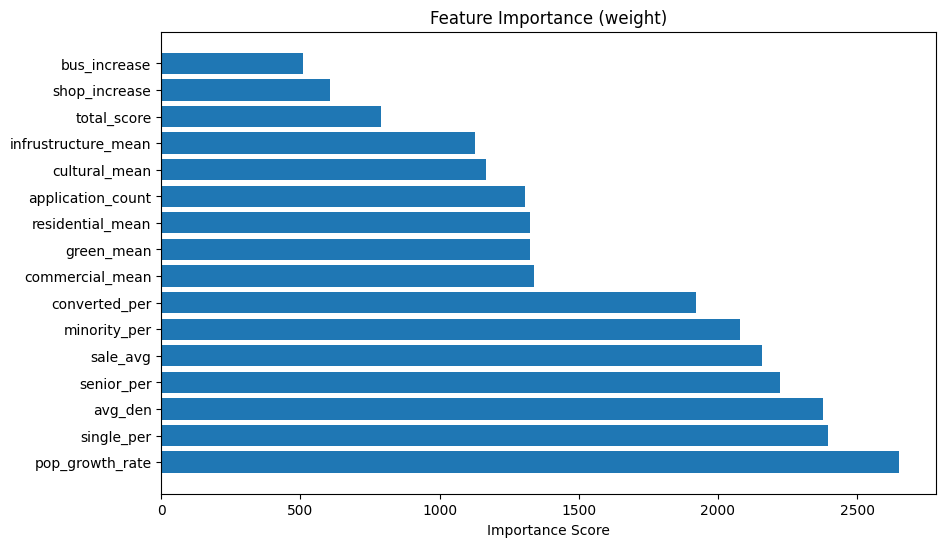

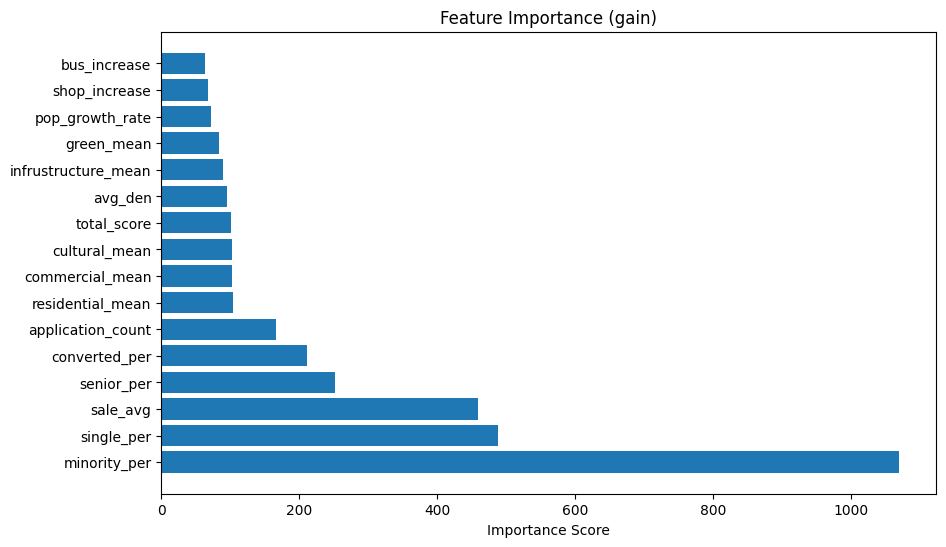

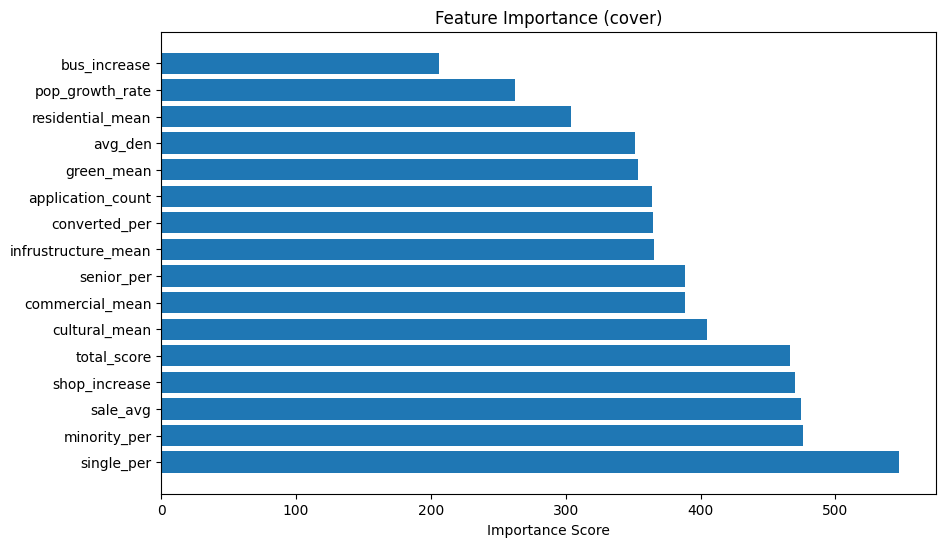

In [110]:
# 获取重要性
importance_types = ['weight', 'gain', 'cover']
for imp_type in importance_types:
    # 获取重要性分数
    importance = model.get_booster().get_score(importance_type=imp_type)
    
    # 转换为DataFrame
    importance_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance': list(importance.values())
    }).sort_values('Importance', ascending=False)
    
    # 可视化
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.title(f'Feature Importance ({imp_type})')
    plt.xlabel('Importance Score')
    plt.show()

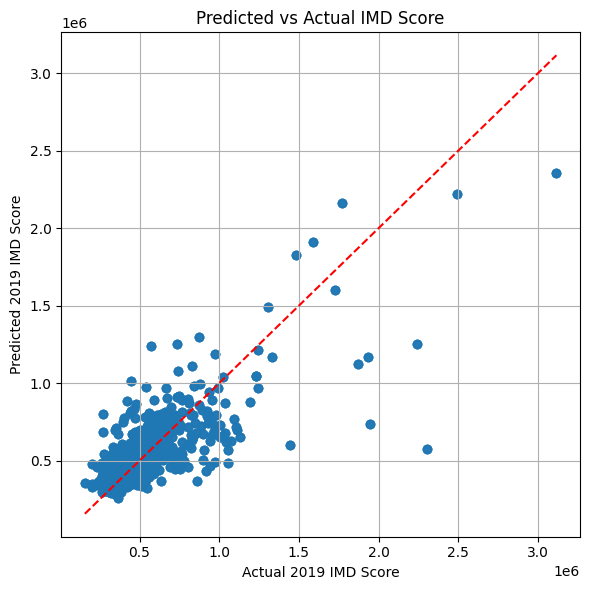

In [116]:
# 模型运行完所有交叉验证后
y_true_all = []   # 收集所有真实值
y_pred_all = []   # 收集所有预测值

for train_idx, test_idx in kf.split(X):
    ...
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# 然后绘图
plt.figure(figsize=(6, 6))
plt.scatter(y_true_all, y_pred_all, alpha=0.4)
plt.plot([min(y_true_all), max(y_true_all)],
         [min(y_true_all), max(y_true_all)], '--r')
plt.xlabel('Actual 2019 IMD Score')
plt.ylabel('Predicted 2019 IMD Score')
plt.title('Predicted vs Actual IMD Score')
plt.grid(True)
plt.tight_layout()
plt.show()
